In [158]:
import os
import pandas as pd
import numpy as np

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import threading
import matplotlib.pyplot as plt

In [140]:
files = ['august.csv', 'september.csv', 'october.csv'] 
PATH ='../data/private/csv/fam/'
df = [pd.read_csv(os.path.join(PATH, file)) 
      for file in files]
df = pd.concat(df, sort=False)

query = '(month == 8 and day >= 27) or (month == 9) or (month == 10 and day <= 7)'
df = df.query(query)

print('Total de registros: %s'%df['month'].count())
df.head()

Total de registros: 26218


,time,sysclass,lat,lon,dir,vel,size,ttyyyxx1,ttyyyxx2,ttyyyxx3,...,maxz,meanvil,ttvil,meanprec,maxprec,year,month,day,hour,minute
12871,0.0,0.0,-2.75,-58.57,-999.0,0.0,13.0,0.0,0.0,0.0,...,22.28,0.18,2.31,0.97,1.18,2014,8,27,2,24
12872,0.2,1.0,-2.73,-58.57,0.0,11.1,30.0,0.0,0.0,0.0,...,28.17,0.30,9.10,1.80,4.16,2014,8,27,2,24
12873,0.0,0.0,-2.73,-58.57,-999.0,0.0,21.0,0.0,0.0,0.0,...,23.01,0.18,3.76,1.02,1.32,2014,8,27,3,0
12874,0.2,1.0,-2.75,-58.57,180.0,11.1,13.0,0.0,0.0,0.0,...,22.28,0.18,2.28,0.97,1.09,2014,8,27,3,0
12875,0.0,0.0,-1.71,-59.63,-999.0,0.0,12.0,0.0,0.0,0.0,...,21.46,0.16,1.96,0.92,0.97,2014,8,27,3,48


In [141]:
def decision_tree(df, records, threshold):
    columns = ['ttyyyxx3', 'riverfrac', 'convfrac', \
           'strafrac', 'meanz', 'maxz', 'meanvil', \
           'ttvil', 'meanprec', 'maxprec']
    
    labels = []
    for i, row in df.iterrows():
        if row[columns[0]] < threshold:
            labels.append(0)
        else:
            labels.append(1)

    df['label'] = labels
    
    no = df[df['label'] == 0].sample(records)
    yes = df[df['label'] == 1].sample(records)
    
    df = pd.concat([no, yes]).sample(records*2)
    
    X_train, X_test, y_train, y_test = train_test_split(df[columns[1:]], \
                                           df[['label']], test_size=.2)
    
    dt = DecisionTreeClassifier().fit(X_train, y_train)
    
    y_pred = dt.predict(X_test)
    
    return confusion_matrix(y_test, y_pred)

In [142]:
cm = decision_tree(df, 1000, 1)
cm

array([[135,  65],
       [ 55, 145]])

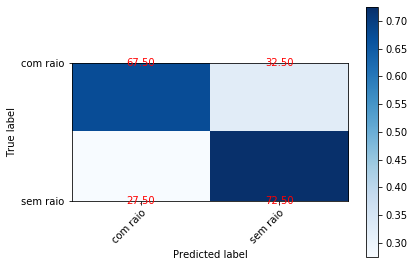

In [156]:
fig, ax = plt.subplots()
cmap=plt.cm.Blues
classes = ['com raio', 'sem raio']
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='',
           ylabel='True label',
           xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fmt = '.2f'
thresh = cm.max() / 2.
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]*100, fmt),
                    ha='center', va='center',
                    color="red" if cm[i, j] > thresh else "red")
fig.tight_layout()

In [148]:
fig = go.Figure()

labels = ['com raios', 'sem raios']
fig.add_trace(
    go.Heatmap(x=labels, y=labels, z=cm*100, colorscale='Blues')
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show()